In [1]:
import sys
sys.path.append('../experiments')

In [2]:
%load_ext autoreload
%autoreload 2

In [14]:
import utils
import joblib
import pandas as pd
# from run_experiment import run_experiment
# import pmsurv_exponential 
import pmsurv_weibull
# import pmsurv_weibull_nn
from sklearn.model_selection import train_test_split
from skopt import BayesSearchCV
# from pmsurv.models.exponential_model import ExponentialModel
from pmsurv.models.weibull_linear import WeibullModelLinear
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pmsurv

In [15]:
SEED = 42

In [20]:
dataset, config = utils.load_data('data/veteran')
train_kwargs = {'jobs': 5, 'n_iter': 10}


In [21]:
dataset['celltype_1:trt'] = dataset['celltype_1'] * dataset['trt_2']
dataset['celltype_2:trt'] = dataset['celltype_2'] * dataset['trt_2']
dataset['celltype_3:trt'] = dataset['celltype_3'] * dataset['trt_2']
dataset['celltype_4:trt'] = dataset['celltype_4'] * dataset['trt_2']

config['features'] = ['age', 'trt_2', 'celltype_2', 'celltype_3', 'celltype_4', 'celltype_2:trt', 'celltype_3:trt', 'celltype_4:trt']
config['preprocessing']['standardize'] = True
config['preprocessing']['continuous_features'] = ['age']
continuous_features = config['preprocessing']['continuous_features']

In [22]:
dataset[config['features']]

,age,trt_2,celltype_2,celltype_3,celltype_4,celltype_2:trt,celltype_3:trt,celltype_4:trt
0,69,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,64,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,38,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,63,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,65,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
132,65,1.0,0.0,0.0,1.0,0.0,0.0,1.0
133,64,1.0,0.0,0.0,1.0,0.0,0.0,1.0
134,67,1.0,0.0,0.0,1.0,0.0,0.0,1.0
135,65,1.0,0.0,0.0,1.0,0.0,0.0,1.0


In [23]:
X_predict_original = pd.DataFrame({
    'age': [50, 50, 65, 65],
    'trt_2': [0, 0, 1, 0],
    'celltype_2': [0, 0, 1, 1], 
    'celltype_3': [1, 1, 0, 0], 
    'celltype_4': [0, 0, 0, 0], 
    'celltype_2:trt': [0, 0, 1, 0], 
    'celltype_3:trt': [1, 0, 0, 0],  
    'celltype_4:trt': [0, 0, 0, 0],
})
X_predict_original

,age,trt_2,celltype_2,celltype_3,celltype_4,celltype_2:trt,celltype_3:trt,celltype_4:trt
0,50,0,0,1,0,0,1,0
1,50,0,0,1,0,0,0,0
2,65,1,1,0,0,1,0,0
3,65,0,1,0,0,0,0,0


In [24]:
def train_model_generic(dataset, config, train_kwargs, preprocess_data_fun, train_fun):
    dataset = dataset.dropna(subset=config['features'])
    X, y = preprocess_data_fun(dataset, config)

    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=config['split']['test_size'],
                                                        shuffle=config['split']['shuffle'])

    if config['preprocessing']['standardize']:
        X_train, X_test, scaler = utils.standardize(X_train, X_test, config)
    else:
        scaler = None

    pipeline, parameters, fit_params = train_fun(X_train, y_train, config, train_kwargs)
    n_cv = 5
    n_points = int(train_kwargs['jobs'] / n_cv)
    opt = BayesSearchCV(pipeline, parameters,
                        fit_params=fit_params,
                        n_jobs=train_kwargs['jobs'],
                        n_points=n_points if n_points > 1 else 1,
                        n_iter=train_kwargs['n_iter'],
                        cv=n_cv,
                        error_score='raise')
    opt.fit(X_train, y_train)
    metrics = opt.best_estimator_.score(X_test, y_test)
    print("Test metrics: " + str(metrics))

    return metrics, opt.best_estimator_, opt.best_params_, scaler, (X_train, X_test, y_train, y_test)

# Train

In [25]:
import pmsurv_weibull

In [26]:
metrics, model_wb, best_params_wb, scaler_wb, _ = train_model_generic(dataset, config, train_kwargs, pmsurv_weibull.preprocess_data, pmsurv_weibull.train_model)

Auto-assigning NUTS sampler...
INFO:pymc.sampling.mcmc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc.sampling.mcmc:Initializing NUTS using jitter+adapt_diag...
Auto-assigning NUTS sampler...
INFO:pymc.sampling.mcmc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc.sampling.mcmc:Initializing NUTS using jitter+adapt_diag...
Auto-assigning NUTS sampler...
INFO:pymc.sampling.mcmc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc.sampling.mcmc:Initializing NUTS using jitter+adapt_diag...
Auto-assigning NUTS sampler...
INFO:pymc.sampling.mcmc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc.sampling.mcmc:Initializing NUTS using jitter+adapt_diag...
Auto-assigning NUTS sampler...
INFO:pymc.sampling.mcmc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc.sampling.mcmc:Initializing NUTS using jitter+adapt_diag...


fitted
Test metrics: 0.6039325842696629


In [27]:
X_predict = X_predict_original.copy()
X_predict[continuous_features] = scaler_wb.transform(X_predict[continuous_features])
surv_wb, surv_wb_lower, surv_wb_upper = model_wb.predict(X_predict)
t_plot_wb = pmsurv.utils.get_time_axis(0, model_wb['model'].max_time, 10) / 30.25

/usr/local/lib/python3.8/dist-packages/pmsurv/models/weibull_base.py:69: UserWarning: The effect of Potentials on other parameters is ignored during posterior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  ppc = pm.sample_posterior_predictive(self.trace, model=self.cached_model, return_inferencedata=False,
Sampling: []
INFO:pymc.sampling.forward:Sampling: []


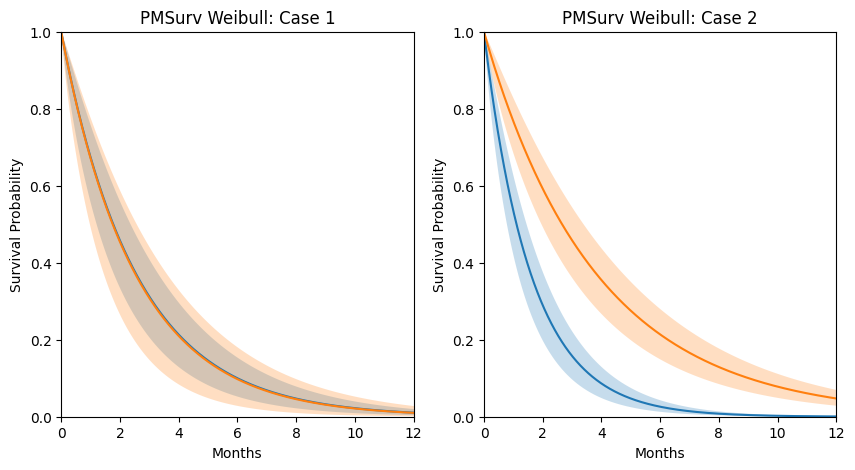

fitted
fitted
fitted
fitted
fitted
fitted
fitted
fitted
fitted
fitted
fitted
fitted
fitted
fitted
fitted
fitted
fitted
fitted
fitted
fitted
fitted
fitted
fitted
fitted
fitted
fitted
fitted
fitted
fitted
fitted
fitted
fitted
fitted
fitted
fitted
fitted
fitted
fitted
fitted
fitted
fitted
fitted
fitted
fitted
fitted
fitted
fitted
fitted
fitted
fitted


In [28]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("PMSurv Weibull: Case 1");
plt.plot(t_plot_wb, surv_wb[0]);
plt.fill_between(t_plot_wb, y1=surv_wb_lower[0], y2=surv_wb_upper[0], alpha=0.25);
plt.plot(t_plot_wb, surv_wb[1]);
plt.fill_between(t_plot_wb, y1=surv_wb_lower[1], y2=surv_wb_upper[1], alpha=0.25);
plt.ylim(0, 1);
plt.xlim(0, 12);
plt.ylabel("Survival Probability");
plt.xlabel("Months");

plt.subplot(1, 2, 2)
plt.title("PMSurv Weibull: Case 2");
plt.plot(t_plot_wb, surv_wb[2]);
plt.fill_between(t_plot_wb, y1=surv_wb_lower[2], y2=surv_wb_upper[2], alpha=0.25);
plt.plot(t_plot_wb, surv_wb[3]);
plt.fill_between(t_plot_wb, y1=surv_wb_lower[3], y2=surv_wb_upper[3], alpha=0.25);
plt.ylim(0, 1);
plt.xlim(0, 12);
plt.ylabel("Survival Probability");
plt.xlabel("Months");

In [29]:
import numpy as np
import seaborn as sns

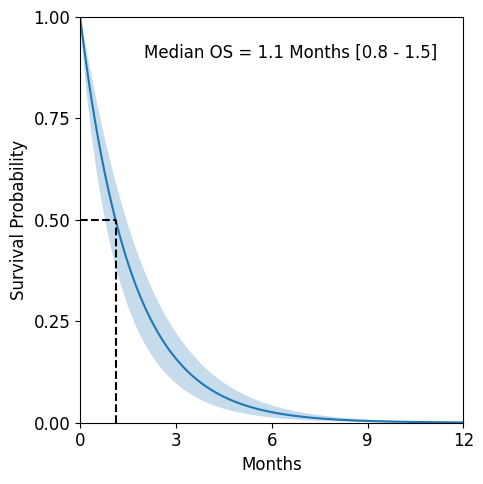

In [70]:
plt.rcParams.update({'font.size': 12})

idx = 2
surv = surv_wb[idx]
surv_lower = surv_wb_lower[idx]
surv_upper = surv_wb_upper[idx]
              
median_os = t_plot_wb[np.argmax(surv < 0.5)]
median_os_lower = t_plot_wb[np.argmax(surv_lower < 0.5)]
median_os_upper = t_plot_wb[np.argmax(surv_upper < 0.5)]

plt.figure(figsize=(5, 5))
ax = sns.lineplot(x=t_plot_wb, y=surv)
plt.fill_between(t_plot_wb, y1=surv_lower, y2=surv_upper, alpha=0.25);
plt.hlines(y=0.5, xmin=0, xmax=median_os, colors='black', linestyles='dashed')
plt.vlines(x=median_os, ymin=0, ymax=0.5, colors='black', linestyles='dashed')
plt.text(x=2, y=0.9, s=f"Median OS = {median_os:0.1f} Months [{median_os_lower:0.1f} - {median_os_upper:0.1f}]")
plt.ylim(0, 1);
plt.xlim(0, 12);
ax.set(xticks=[0, 3, 6, 9, 12], yticks=[0, 0.25, 0.5, 0.75, 1], ylabel='Survival Probability', xlabel='Months');
plt.tight_layout()
plt.savefig('fig1_b.svg')

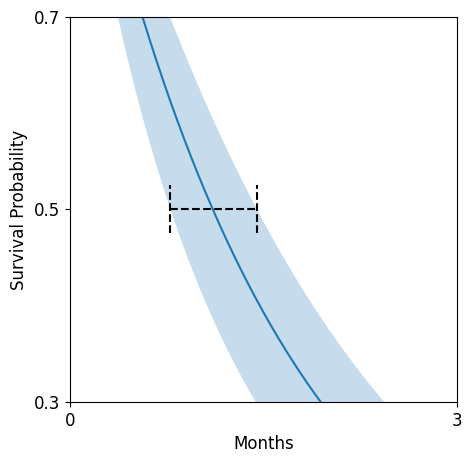

In [69]:
plt.rcParams.update({'font.size': 12})

plt.figure(figsize=(5, 5))
ax = sns.lineplot(x=t_plot_wb, y=surv)
plt.fill_between(t_plot_wb, y1=surv_lower, y2=surv_upper, alpha=0.25);
plt.hlines(y=0.5, xmin=median_os_lower, xmax=median_os_upper, colors='black', linestyles='dashed')
plt.vlines(x=median_os_lower, ymin=0.475, ymax=0.525, colors='black', linestyles='dashed')
plt.vlines(x=median_os_upper, ymin=0.475, ymax=0.525, colors='black', linestyles='dashed')

# plt.text(x=3, y=0.75, s=f"Median OS = {median_os:0.1f} Months [{median_os_lower:0.1f} - {median_os_upper:0.1f}]")
plt.ylim(0.3, 0.7);
plt.xlim(1, 3);
ax.set(xticks=[0, 3], yticks=[0.3, 0.5, 0.7], ylabel='Survival Probability', xlabel='Months');
plt.savefig('fig1_c.svg')

In [32]:
import arviz as az

In [33]:
import seaborn as sns

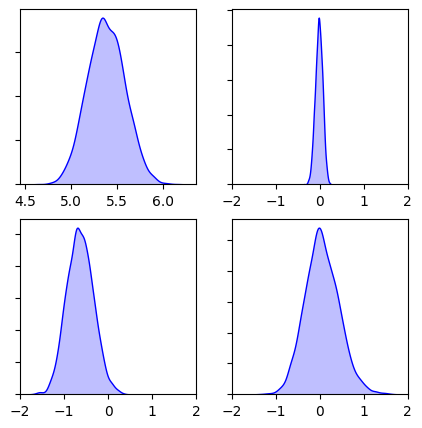

In [34]:
xlimits = [-2, 2]
plt.rcParams.update({'font.size': 12})
plt.figure(figsize=(5, 5))
plt.subplot(2, 2, 1)
posterior = model_wb['model'].trace.posterior['lambda_intercept'].values.flatten()
ax = sns.kdeplot(posterior, color='blue', fill=True);
# plt.xlim(xlimits)
# ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[], ylabel='');
ax.set(yticklabels=[], ylabel='');


plt.subplot(2, 2, 2)
posterior = model_wb['model'].trace.posterior['k_intercept'].values.flatten()
ax = sns.kdeplot(posterior, color='blue', fill=True);
# ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[], ylabel='');
ax.set(yticklabels=[], ylabel='');

plt.xlim(xlimits)

plt.subplot(2, 2, 3)
posterior = model_wb['model'].trace.posterior['lambda_column_0'].values.flatten()
ax = sns.kdeplot(posterior, color='blue', fill=True);
# ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[], ylabel='');
ax.set(yticklabels=[], ylabel='');
plt.xlim(xlimits)

plt.subplot(2, 2, 4)
posterior = model_wb['model'].trace.posterior['lambda_column_2'].values.flatten()
ax = sns.kdeplot(posterior, color='blue', fill=True);
# ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[], ylabel='');
ax.set(yticklabels=[], ylabel='');
plt.xlim(xlimits);


In [35]:
model_wb['model'].trace.posterior.keys()


KeysView(<xarray.Dataset>
Dimensions:           (chain: 2, draw: 2000, lambda_det_dim_0: 109,
                       k_det_dim_0: 109)
Coordinates:
  * chain             (chain) int64 0 1
  * draw              (draw) int64 0 1 2 3 4 5 ... 1994 1995 1996 1997 1998 1999
  * lambda_det_dim_0  (lambda_det_dim_0) int64 0 1 2 3 4 ... 104 105 106 107 108
  * k_det_dim_0       (k_det_dim_0) int64 0 1 2 3 4 5 ... 104 105 106 107 108
Data variables:
    lambda_intercept  (chain, draw) float64 5.376 5.546 5.456 ... 5.156 5.587
    k_intercept       (chain, draw) float64 -0.04456 0.05307 ... -4.674e-05
    lambda_column_0   (chain, draw) float64 -1.049 -0.5766 ... -0.5729 -0.8719
    lambda_column_1   (chain, draw) float64 -0.6382 -1.16 ... -1.987 -0.4059
    lambda_column_2   (chain, draw) float64 0.1536 -0.4942 ... 0.1655 -0.492
    lambda_column_3   (chain, draw) float64 -0.463 -1.083 ... -0.8395 -0.8343
    lambda_column_4   (chain, draw) float64 -0.3361 -0.1257 ... 1.181 -0.9465
    lambda_co

In [47]:
cols = ['lambda_intercept', 'celltype_2', 'celltype_3', 'celltype_4', 'celltype_2:trt', 'celltype_3:trt', 'celltype_4:trt']
cols_post = ['lambda_intercept',  'lambda_column_0', 'lambda_column_1', 'lambda_column_2', 'lambda_column_3', 'lambda_column_4', 'lambda_column_5']


In [48]:
df_posteriors = pd.DataFrame({
    'column': np.repeat(cols, 4000),
    'samples': np.concatenate([model_wb['model'].trace.posterior[c].values.flatten() for c in cols_post])
})

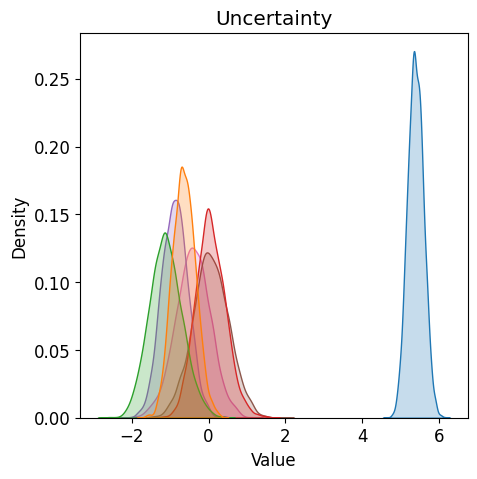

In [88]:
plt.rcParams.update({'font.size': 12})

plt.figure(figsize=(5, 5))
# plt.subplot(1, 1, 1)
plt.title("Uncertainty")
ax = sns.kdeplot(data = df_posteriors, x = 'samples', hue='column', fill=True, legend=None);
# ax.set(xlabel='Parameters');
plt.xlabel('Value')
# plt.tight_layout()
# plt.subplots_adjust(bottom=0.5)
plt.savefig('fig_1_c.svg');

In [50]:
import pymc as pm

In [51]:
with pm.Model() as model:
    lambda_intercept = pm.Normal("λ_intercept", mu=0, sigma=1)
    k_intercept = pm.Normal("κ_intercept", mu=0, sigma=1)
    
    lambda_1 = pm.Normal("λ_age", mu=0, sigma=1)
    lambda_2 = pm.Normal("λ_trt", mu=0, sigma=1)
    lambda_3 = pm.Normal("λ_celltype", mu=0, sigma=1)
    
    lambda_det = pm.Deterministic('λ', pm.math.exp(lambda_intercept + lambda_1 + lambda_2 + lambda_3))
    k_det = pm.Deterministic('κ', pm.math.exp(k_intercept))
    
    y = pm.Weibull('y', alpha=k_det, beta=lambda_det)
    

In [53]:
cols = ['lambda_intercept', 'celltype_2', 'celltype_3', 'celltype_4', 'celltype_2:trt', 'celltype_3:trt', 'celltype_4:trt']
cols_post = ['lambda_intercept',  'lambda_column_0', 'lambda_column_1', 'lambda_column_2', 'lambda_column_3', 'lambda_column_4', 'lambda_column_5']

df_posterior = pd.DataFrame({
    'column': np.repeat(cols, 4000),
    'grp': np.repeat('posterior', len(cols)*4000),
    'samples': np.concatenate([model_wb['model'].trace.posterior[c].values.flatten() for c in cols_post])
})

df_prior = pd.DataFrame({
    'column': np.repeat(cols, 4000),
    'grp': np.repeat('prior', len(cols)*4000),
    'samples': np.concatenate([model_wb['model'].trace.prior[c].values.flatten() for c in cols_post])
})

AttributeError: 'InferenceData' object has no attribute 'prior'

In [43]:
model_wb['model'].trace

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data
	> constant_data

In [54]:
sns.kdeplot(data = df_bayes[df_bayes['column'] == 'trt_2'], 
            x = 'samples', hue='grp', fill=True);



NameError: name 'df_bayes' is not defined